# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Exampel](../static_files/mnist.png)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network which encodes prior knowledge about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [2]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

In [3]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 784).float()
targets_test = mnist_testset.targets[:500]

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([1000, 784])
targets_train torch.Size([1000])
x_valid torch.Size([500, 784])
targets_valid torch.Size([500])
x_test torch.Size([500, 784])
targets_test torch.Size([500])


/var/folders/qs/5nthhxwd0mvfmc02zfmpp2380000gn/T/ipykernel_5958/2070944429.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))


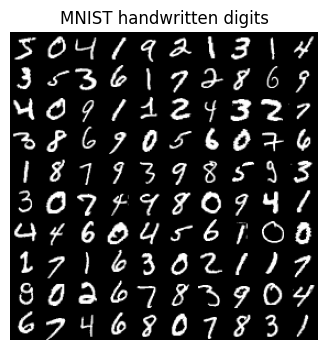

In [4]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaiming He
2. Xavier Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. ELU
3. Sigmoid (rarely, if ever, used in hidden layers anymore, squashes the output to the interval [0, 1] - appropriate if the targets are binary.
4. Tanh is similar to the sigmoid, but squashes to [-1, 1]. Rarely used any more.
4. Softmax normalizes the output to 1, usrful if you have a multi-class classification problem.

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 0.01 - 0.1 
2. ADAM: learning rate 3e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


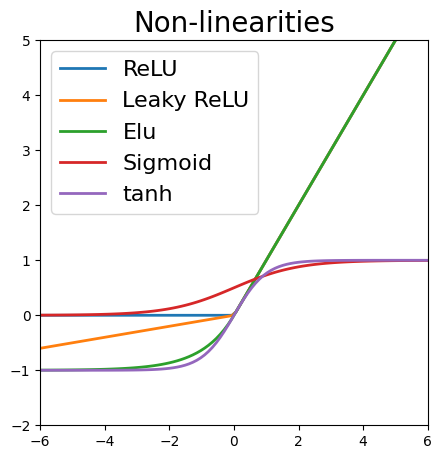

In [5]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [6]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return x


net = Net(num_features, num_l1, num_classes)

In [7]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [8]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(torch.from_numpy(x)).size())

torch.Size([45, 10])


# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

Epoch  1 : Train Loss 0.232760 , Train acc 0.198000, Valid acc 0.210000
Epoch 11 : Train Loss 0.107356 , Train acc 0.803000, Valid acc 0.764000
Epoch 21 : Train Loss 0.075206 , Train acc 0.841000, Valid acc 0.798000
Epoch 31 : Train Loss 0.061078 , Train acc 0.862000, Valid acc 0.818000
Epoch 41 : Train Loss 0.052809 , Train acc 0.872000, Valid acc 0.824000
Epoch 51 : Train Loss 0.047198 , Train acc 0.883000, Valid acc 0.826000


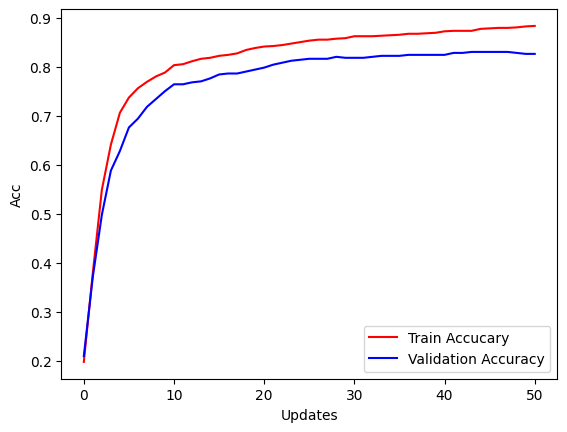

In [9]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

# setting hyperparameters and settings epoch sizes
batch_size = 100
num_epochs = 51
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()



In [10]:
# Test accuracy and loss
net.eval()
output = net(x_test)
preds = torch.max(output, 1)[1]
print("Accuracy on test set: ", accuracy_score(targets_test, preds.data.numpy()))

Accuracy on test set:  0.82


# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on clever use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

-------------
| :exclamation:  Important Note  |
|-----------------------------------------|

> # Assignment solution follows from here onwards !!!

--------

In [20]:
# Use more data from MNIST dataset
train_size = 1000
valid_size = 500
test_size = 500

# Reset data splittings in training, validation and testing
x_train = mnist_trainset.data[:train_size].view(-1, 784).float()
targets_train = mnist_trainset.targets[:train_size]

x_valid = mnist_trainset.data[train_size : train_size + valid_size].view(-1, 784).float()
targets_valid = mnist_trainset.targets[train_size : train_size + valid_size]

x_test = mnist_testset.data[:test_size].view(-1, 784).float()
targets_test = mnist_testset.targets[:test_size]

In [21]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 192
num_l3 = 64
num_features = x_train.shape[1]
weight_decay_rate = 5e-5
dropout_rate =  0.5
# define network
class Net(nn.Module):

    def __init__(self, num_features: int, num_hidden: list, num_output: int):
        super(Net, self).__init__() 
         
        # input layer
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden[0], num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden[0]), 0))
        
        # hidden layer
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden[1], num_hidden[0])))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden[1]), 0))
        
        # another one ;) xavier initialization more efficient for later layers
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor((num_hidden[2]), num_hidden[1])))
        self.b_3 = Parameter(init.constant_(torch.Tensor((num_hidden[2])), 0))
        
        # another one ;)
        self.W_4 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden[2])))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        
        # batch normalization
        self.bat1 = nn.BatchNorm1d(num_hidden[0])
        self.bat2 = nn.BatchNorm1d(num_hidden[1])
        self.bat3 = nn.BatchNorm1d(num_hidden[2])
        
        # dropout layer
        self.dropout = nn.Dropout1d(p=dropout_rate) # Add dropout 
        
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.bat1(x) # Call the batch normalization
        x = self.activation(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.bat2(x) # Call the batch normalization
        x = self.activation(x)
        
        x = self.dropout(x) # Call the dropout layer - better in between bigger layers and towards the end
        
        x = F.linear(x, self.W_3, self.b_3)
        x = self.bat3(x) # Call the batch normalization
        x = self.activation(x)
                
        x = F.linear(x, self.W_4, self.b_4)
        return x


net = Net(num_features, [num_l1, num_l2, num_l3], num_classes)

In [22]:
# optimizer = optim.SGD(net.parameters(), lr=0.1e-2, momentum=0.9, weight_decay=weight_decay_rate)
optimizer = optim.Adam(net.parameters(), lr=5e-3, weight_decay=weight_decay_rate) # ADAM optimizer with L2 regularization
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) # Scheduler for more efficient learning
criterion = nn.CrossEntropyLoss()


Epoch  1 : Train Loss 0.182621 , Train acc 0.849000, Valid acc 0.748000
Epoch  6 : Train Loss 0.121348 , Train acc 0.991000, Valid acc 0.874000
Epoch 11 : Train Loss 0.116662 , Train acc 0.999000, Valid acc 0.858000
Epoch 16 : Train Loss 0.112581 , Train acc 1.000000, Valid acc 0.870000
Epoch 21 : Train Loss 0.113251 , Train acc 1.000000, Valid acc 0.868000
Epoch 26 : Train Loss 0.119755 , Train acc 1.000000, Valid acc 0.872000
Epoch 31 : Train Loss 0.114762 , Train acc 1.000000, Valid acc 0.870000


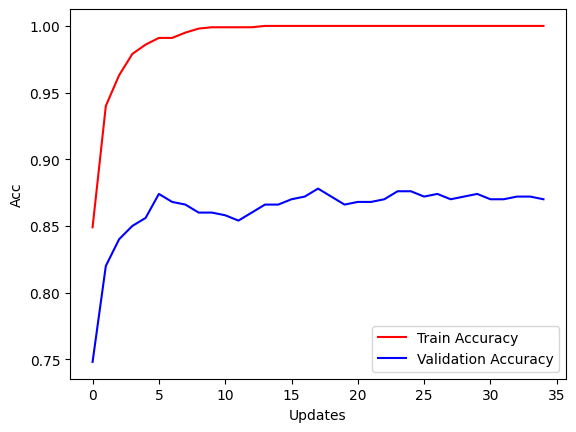

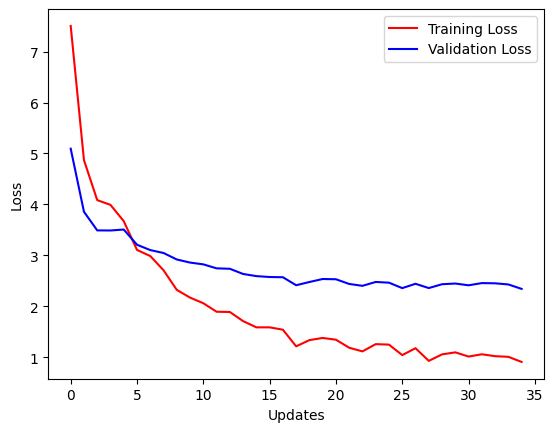

Accuracy on test set:  0.902


In [23]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

# setting hyperparameters and settings epoch sizes
batch_size = 100
num_epochs = 35
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss 
    scheduler.step()
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    t_loss = 0
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        
        output = net(x_train[slce])
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
        
        t_loss += criterion(output, targets_train[slce]).detach().numpy()
        
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    v_loss = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        
        v_loss += criterion(output, targets_valid[slce]).detach().numpy()
        
    # scheduler.step(v_loss)  

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    
    if epoch % 5 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()

plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss, 'b')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()


# Test accuracy and loss
net.eval()
output = net(x_test)
preds = torch.max(output, 1)[1]
print("Accuracy on test set: ", accuracy_score(targets_test, preds.data.numpy()))


You are done for now. [Good job.](https://media1.tenor.com/images/0fd559b07f2174f9b8b7dbde7c5a67ca/tenor.gif)

# Book Exercise - Michael Nielsen's 'Neural Networks and Deep Learning'

### **Gradient Descent for 1D functions:**
We explained gradient descent when C is a function of two variables, and when it's a function of more than two variables. What happens when C is a function of just one variable? 
Can you provide a geometric interpretation of what gradient descent is doing in the one-dimensional case?

`Solution:` The gradient descent in 1D is quite similar to the Newton-Raphson method for computing approximately the root of a real-valued function. The algorithm takes steps towards the desired optimum point, having the momentum determined by the derivative of the function. In the case of gradient descent, the derivative of $C$, namely $C'$ would be used to determine the momentum and direction towards the optimum point. Geometrically, the algorithm would behave like a ball rolling off to find the valley between two peeks.

### **Backpropagation with linear neurons:**
Suppose we replace the usual non-linear $\sigma$ function with $\sigma(z)=z$ throughout the network. Rewrite the back-propagation algorithm for this case.

`Solution:` In case of a linear (identity) $\sigma$ function, the error would be represented by:
$$
\delta^L = \nabla_a C \odot 1, \text{ since } \sigma'(z) = \frac{\partial}{\partial z}z = 1 
$$ 
and the backpropagated error will be quantified by:
$$
\delta^l = ((w^{l+1})^T \delta^{l+1})
$$

### **Bitwise Representation of Digits**

There is a way of determining the bitwise representation of a digit by adding an extra layer to the three-layer network above. The extra layer converts the output from the previous layer into a binary representation, as illustrated in the figure below. Find a set of weights and biases for the new output layer. Assume that the first 3 layers of neurons are such that the correct output in the third layer (i.e., the old output layer) has activation at least $0.99$, and incorrect outputs have activation less than $0.01$.

In this task we need to convert $10$ digits (from $0$ to $9$) into binary representation. To do this, we need another layer consisting of 4 neurons, because this is the minimum number of neurons that will allow us to encode $10$ digits in binary ($4*4=16$). The goal is to find the right set of weights and loads for the new output layer. To do this, we need to construct an activation function that returns 0 or 1 based on the activation from the previous layer. For the following numbers, we adopt the following binary representations:
```bash
0 = 0000; 1 = 0001; 2 = 0010; 3 = 0011; 4 = 0100
5 = 0101; 6 = 0110; 7 = 0111; 8 = 1000; 9 = 1001
```

In [1883]:
#binary converting layer
import numpy as np

# weights
#The weight matrix is set up such that each row represents the weights needed to calculate a specific bit in the binary representation based on the activated neuron in the previous layer.
#array presents 10 columns, as a 10 numbers to be coded using 4 neurons (b0,b1,b2,b3)

W = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1], # b3
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0], # b2
    [0, 0, 1, 1, 0, 0, 1, 1, 0, 0], # b1
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 1], # b0
])

# In this case we use a bias of -0.5, which allows us to keep the bits 
#   inactive unless the corresponding neuron is highly activated.
b = np.array([-0.5, -0.5, -0.5, -0.5])

# Function forward_pass to count binary representation
def forward_pass(output_from_previous_layer):
    bitwise_representation = np.dot(W, output_from_previous_layer) + b
    bitwise_representation = (bitwise_representation > 0).astype(int)
    return bitwise_representation

# Testing function for representation of 9
previous_layer_output = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
bitwise_output = forward_pass(previous_layer_output)
print(bitwise_output)


[1 0 0 1]
